# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '13'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_rime_ice_snow.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2557985)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 19:13:42 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_snow.values
    ni   = xr.open_dataset(fname).n_snow.values
    cwc  = xr.open_dataset(fname).cwc.values
    r_c  = xr.open_dataset(fname).rc.values    
    # process rates
    rime_snow_cloud_num   = xr.open_dataset(fname).rime_snow_cloud_num.values
    rime_snow_cloud_mass  = xr.open_dataset(fname).rime_snow_cloud_mass.values
    rime_snow_cloud_rmass = xr.open_dataset(fname).rime_snow_cloud_rmass.values
    rime_snow_cloud_rvol  = xr.open_dataset(fname).rime_snow_cloud_rvol.values
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*ni)
    cwc = np.log(cwc, where=cwc>q_min, out=np.nan*ni)
    r_c = np.log(r_c, where=r_c>q_min, out=np.nan*ni)
    rime_snow_cloud_num  = np.log(rime_snow_cloud_num,  where=rime_snow_cloud_num>p_min,  out=np.nan*rime_snow_cloud_num)    
    rime_snow_cloud_mass = np.log(rime_snow_cloud_mass, where=rime_snow_cloud_mass>p_min, out=np.nan*rime_snow_cloud_mass)
    rime_snow_cloud_rmass = np.log(rime_snow_cloud_rmass,where=rime_snow_cloud_rmass>p_min, out=np.nan*rime_snow_cloud_rmass)
    rime_snow_cloud_rvol  = np.log(rime_snow_cloud_rvol, where=rime_snow_cloud_rvol>p_min, out=np.nan*rime_snow_cloud_rvol)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, cwc, r_c, temp, rho, rime_snow_cloud_num, rime_snow_cloud_mass, rime_snow_cloud_rmass, rime_snow_cloud_rvol ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'cwc', 'rc', 'temp', 'rho', 'rime_snow_cloud_num', 'rime_snow_cloud_mass', 'rime_snow_cloud_rmass', 'rime_snow_cloud_rvol' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi        ni        cwc         rc        temp    rho  \
186 -16.857517  2.679513  -8.772085 -12.155304  265.890015  1.038   
394 -10.379333  8.499763  -8.804875 -11.148866  261.670013  0.926   
397 -11.886427  7.332696  -9.756793 -11.148866  262.309998  0.936   
400 -11.849671  7.155552 -12.740508 -11.148866  263.040009  0.948   
412 -13.499679  5.689515  -7.571343 -11.148866  266.049988  0.998   

     rime_snow_cloud_num  rime_snow_cloud_mass  rime_snow_cloud_rmass  \
186             0.361820            -19.165255             -24.964981   
394             4.851053            -13.538198             -17.930555   
397             1.221936            -17.674486             -21.720713   
400            -2.995732            -21.492765             -29.298195   
412             3.087769            -20.217268             -20.217268   

     rime_snow_cloud_rvol  
186            -29.975613  
394            -22.941565  
397            -26.731348  
400            -34.308830  
412            -24.616251

In [10]:
dataset_train.describe()

qi            ni           cwc            rc          temp  \
count  11643.000000  11643.000000  11643.000000  11643.000000  11643.000000   
mean     -13.597480      5.216283     -8.488100    -10.987040    261.729675   
std        4.167859      5.176847      1.521227      0.462079      6.891297   
min      -34.324955    -14.357827    -28.603882    -12.201623    245.600006   
25%      -16.244350      2.805479     -9.396670    -11.308622    255.955002   
50%      -12.829432      6.463902     -8.454218    -10.948152    263.369995   
75%      -10.436133      8.752518     -7.520245    -10.590967    267.089996   
max       -4.150343     14.372724     -3.872802    -10.260991    273.140015   

                rho  rime_snow_cloud_num  rime_snow_cloud_mass  \
count  11643.000000         11643.000000          11643.000000   
mean       0.954510            -1.395201            -20.192499   
std        0.108899             4.881245              4.259335   
min        0.713000           -16.801191            -37.225670   
25%        0.863000            -3.935742            -23.129700   
50%        0.963000            -0.718465            -20.151529   
75%        1.036000             2.110497            -16.966495   
max        1.262000             9.569636             -7.688995   

       rime_snow_cloud_rmass  rime_snow_cloud_rvol  
count           11643.000000          11643.000000  
mean              -23.154528            -28.272713  
std                 4.699727              4.794445  
min               -40.722507            -45.733139  
25%               -26.373955            -31.588784  
50%               -22.694729            -27.828562  
75%               -19.510434            -24.544456  
max                -9.780677            -14.791312

In [11]:
dataset_test.describe()

qi           ni          cwc           rc         temp  \
count  2467.000000  2467.000000  2467.000000  2467.000000  2467.000000   
mean    -13.489876     5.430067    -8.506894   -10.983392   261.732025   
std       4.080016     5.054300     1.490083     0.457017     6.897875   
min     -27.960415   -14.467842   -22.432524   -12.191578   246.210007   
25%     -16.044705     3.034557    -9.384100   -11.289930   255.790001   
50%     -12.761930     6.489585    -8.449534   -10.940676   263.470001   
75%     -10.420289     8.909226    -7.588974   -10.593428   267.100006   
max      -4.391189    14.105266    -4.086376   -10.261048   273.130005   

               rho  rime_snow_cloud_num  rime_snow_cloud_mass  \
count  2467.000000          2467.000000           2467.000000   
mean      0.956369            -1.221618            -20.113277   
std       0.109643             4.811881              4.175622   
min       0.713000           -16.770422            -37.271461   
25%       0.864000            -3.753418            -23.081850   
50%       0.968000            -0.592171            -20.013512   
75%       1.038500             2.121794            -17.012538   
max       1.238000             9.310149             -9.287725   

       rime_snow_cloud_rmass  rime_snow_cloud_rvol  
count            2467.000000           2467.000000  
mean              -23.034023            -28.153412  
std                 4.612262              4.698128  
min               -39.995972            -45.988785  
25%               -26.304031            -31.432483  
50%               -22.481743            -27.592936  
75%               -19.564957            -24.645188  
max               -12.339474            -17.351606

In [12]:
dataset_val.describe()

qi           ni          cwc           rc         temp  \
count  2569.000000  2569.000000  2569.000000  2569.000000  2569.000000   
mean    -13.599376     5.426344    -8.482158   -10.966658   261.688873   
std       4.107121     4.967072     1.596689     0.454096     6.932455   
min     -33.479874   -13.928836   -25.992025   -12.201045   245.809998   
25%     -16.097803     3.085344    -9.418595   -11.271832   255.830002   
50%     -12.914536     6.510392    -8.449534   -10.920494   263.359985   
75%     -10.524277     8.801394    -7.496542   -10.575155   267.140015   
max      -4.138798    14.353056    -4.374058   -10.260991   273.119995   

               rho  rime_snow_cloud_num  rime_snow_cloud_mass  \
count  2569.000000          2569.000000           2569.000000   
mean      0.953136            -1.244843            -20.233946   
std       0.109115             4.773349              4.226937   
min       0.711000           -16.660421            -37.764183   
25%       0.860000            -3.896519            -23.087023   
50%       0.964000            -0.597837            -20.072332   
75%       1.038000             2.147210            -17.057259   
max       1.242000             8.994184             -8.386643   

       rime_snow_cloud_rmass  rime_snow_cloud_rvol  
count            2569.000000           2569.000000  
mean              -23.138475            -28.269318  
std                 4.710756              4.811541  
min               -40.865311            -45.875942  
25%               -26.269836            -31.523491  
50%               -22.660500            -27.777050  
75%               -19.579782            -24.616747  
max               -11.695783            -16.706419

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['cwc'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qi            ni           cwc            rc          temp  \
count  10492.000000  10492.000000  10492.000000  10492.000000  10492.000000   
mean     -12.735776      5.917289     -8.526844    -10.962764    261.157471   
std        3.272940      4.883841      1.385670      0.454611      6.860561   
min      -19.996056    -14.357827    -13.738549    -12.201623    245.600006   
25%      -15.081855      4.093573     -9.460085    -11.269627    255.177494   
50%      -12.375439      6.917059     -8.527244    -10.913745    262.690002   
75%      -10.208709      9.039083     -7.598905    -10.570436    266.739990   
max       -4.150343     14.372724     -3.872802    -10.260991    273.000000   

                rho  rime_snow_cloud_num  rime_snow_cloud_mass  \
count  10492.000000         10492.000000          10492.000000   
mean       0.946222            -0.856061            -19.499777   
std        0.107875             4.749022              3.779211   
min        0.713000           -16.801191            -36.189266   
25%        0.854000            -2.995732            -22.225051   
50%        0.954000            -0.187648            -19.567626   
75%        1.028000             2.413398            -16.636922   
max        1.247000             9.569636             -7.688995   

       rime_snow_cloud_rmass  rime_snow_cloud_rvol  
count           10492.000000          10492.000000  
mean              -22.396618            -27.495243  
std                 4.168777              4.256905  
min               -40.219009            -45.526600  
25%               -25.220301            -30.371558  
50%               -22.112307            -27.179709  
75%               -19.223922            -24.261956  
max                -9.780677            -14.791312

In [16]:
dataset_test.describe()

qi           ni          cwc           rc         temp  \
count  2245.000000  2245.000000  2245.000000  2245.000000  2245.000000   
mean    -12.724109     6.052434    -8.538182   -10.961355   261.188599   
std       3.284627     4.781441     1.401381     0.448225     6.874421   
min     -19.999735   -14.467842   -17.449902   -12.191578   246.210007   
25%     -15.064481     4.138904    -9.449867   -11.250216   255.110001   
50%     -12.342626     6.991821    -8.492500   -10.907801   262.890015   
75%     -10.199497     9.165375    -7.658532   -10.582381   266.649994   
max      -4.391189    14.105266    -4.086376   -10.261048   273.000000   

               rho  rime_snow_cloud_num  rime_snow_cloud_mass  \
count  2245.000000          2245.000000           2245.000000   
mean      0.948384            -0.722449            -19.489920   
std       0.108809             4.662652              3.722121   
min       0.713000           -16.770422            -34.353436   
25%       0.854000            -2.995732            -22.284643   
50%       0.957000            -0.091567            -19.451897   
75%       1.030000             2.417029            -16.714718   
max       1.226000             9.310149             -9.287725   

       rime_snow_cloud_rmass  rime_snow_cloud_rvol  
count            2245.000000           2245.000000  
mean              -22.354235            -27.458784  
std                 4.130197              4.217252  
min               -38.216351            -43.287846  
25%               -25.263294            -30.472397  
50%               -21.991617            -27.072098  
75%               -19.197821            -24.278797  
max               -12.339474            -17.351606

### Pairplot

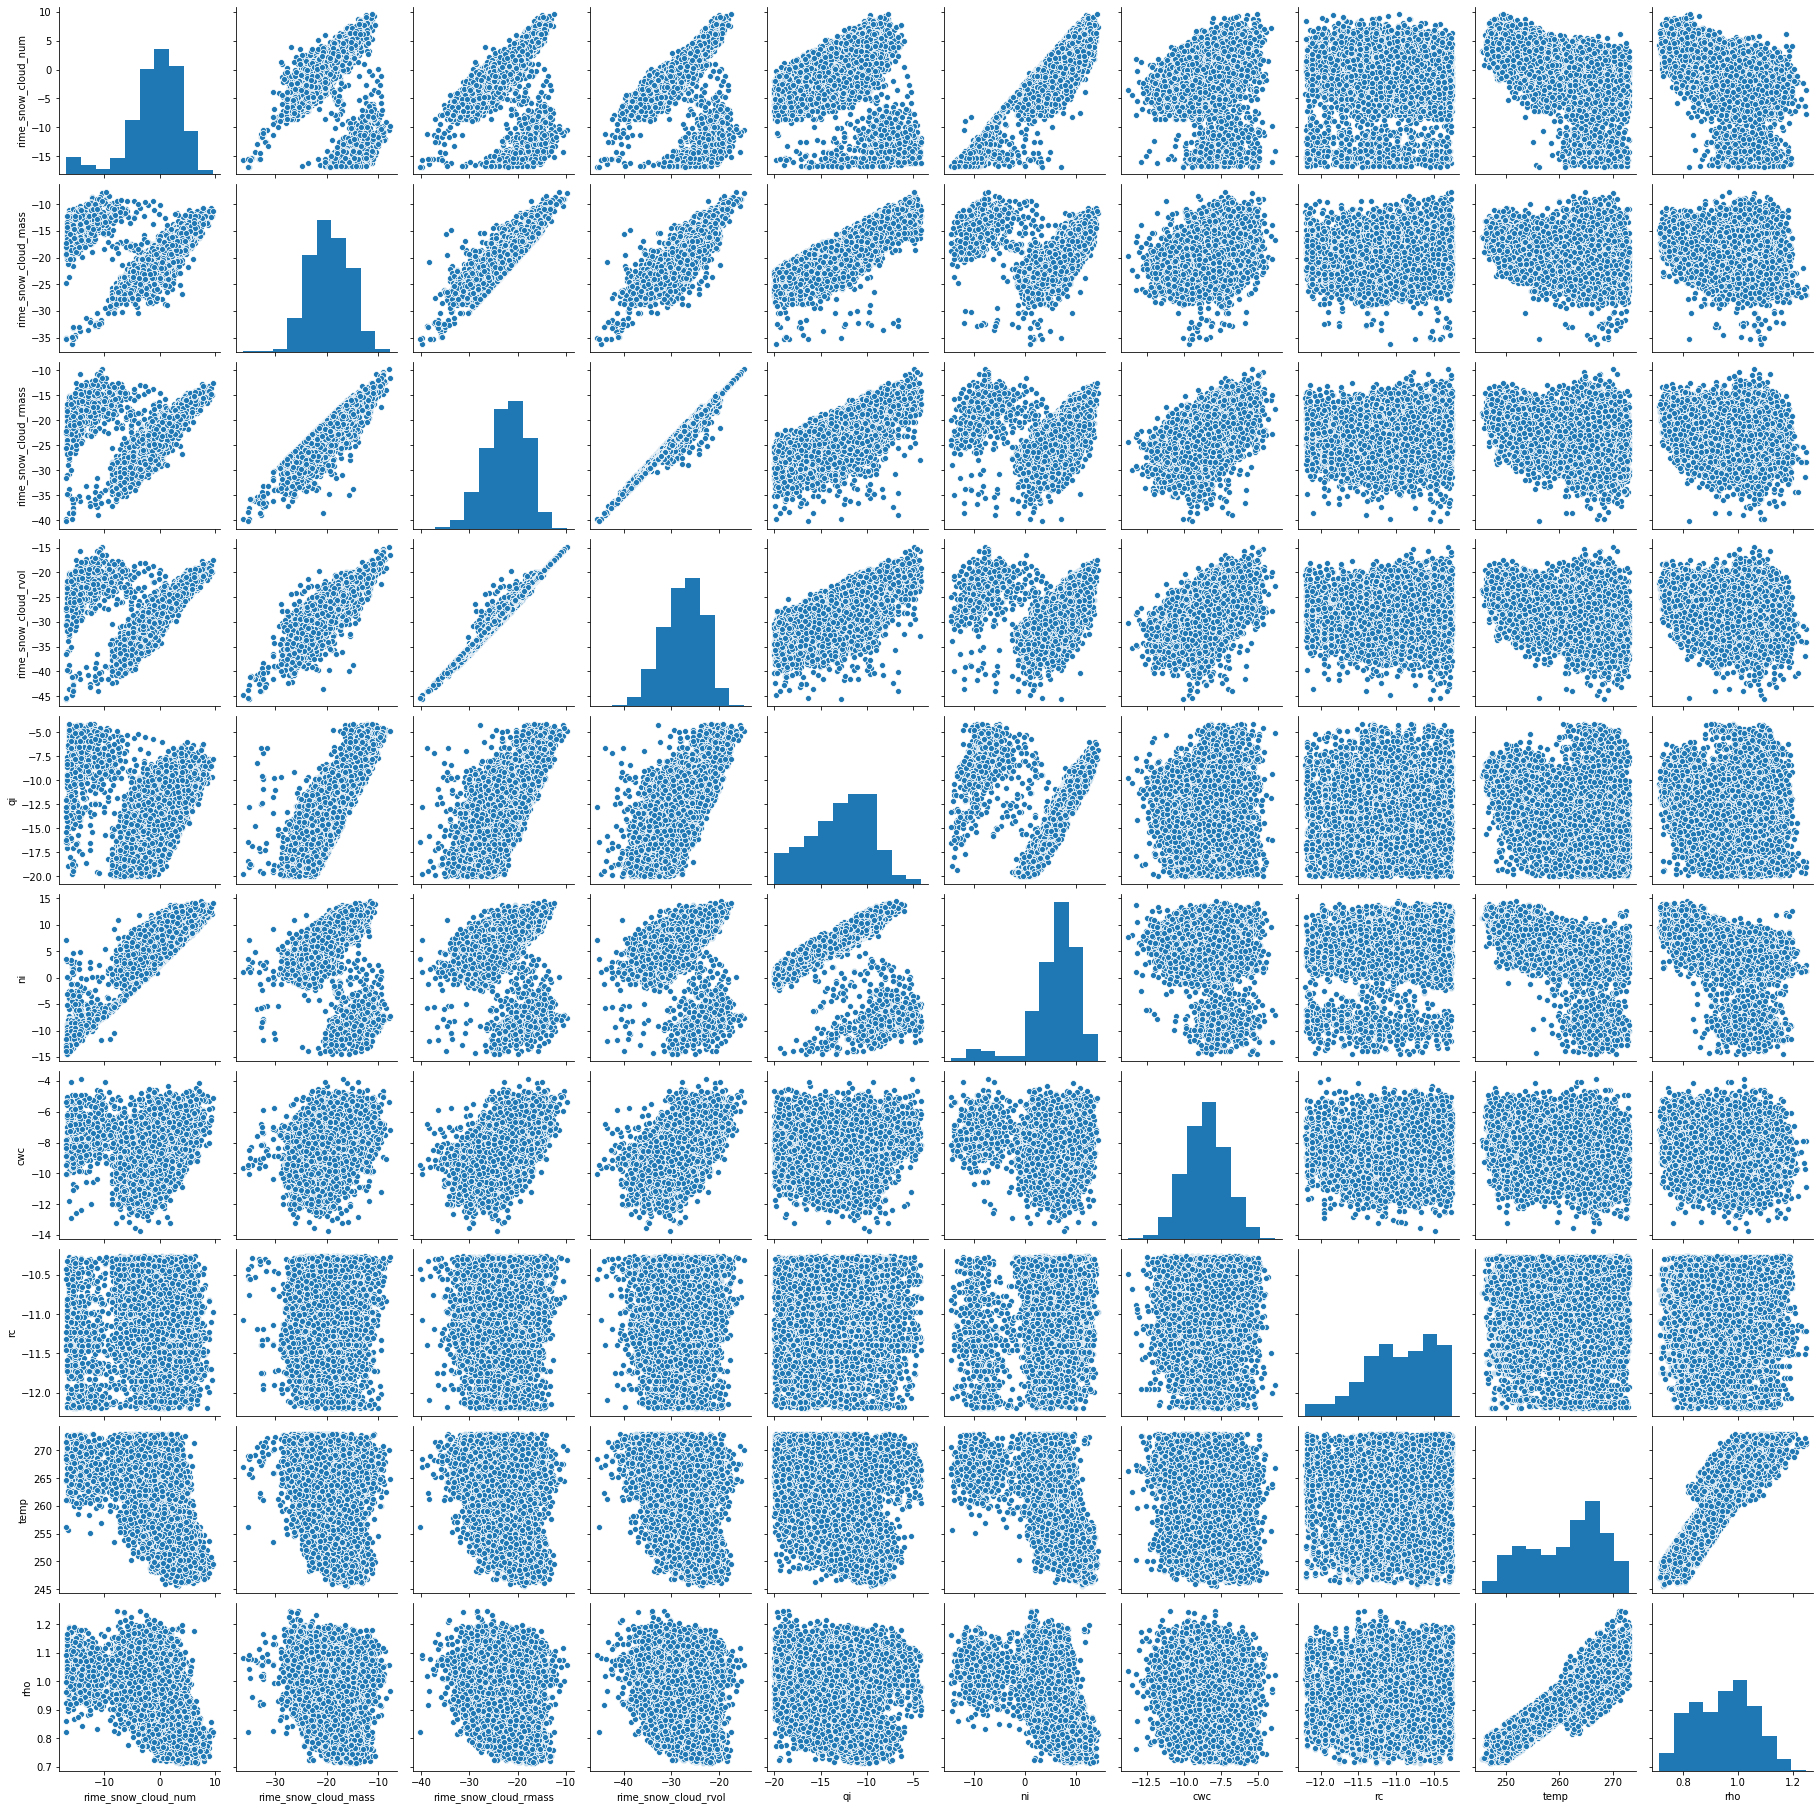

In [17]:
sns.pairplot(dataset_train[["rime_snow_cloud_num","rime_snow_cloud_mass","rime_snow_cloud_rmass","rime_snow_cloud_rvol","qi","ni","cwc","rc","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [21]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [22]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [23]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("rime_snow_cloud_num")
train_stats1.pop("rime_snow_cloud_mass")
train_stats1.pop("rime_snow_cloud_rmass")
train_stats1.pop("rime_snow_cloud_rvol")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
qi   10492.0 -12.735776  3.272940 -19.996056 -15.081855 -12.375439 -10.208709   
ni   10492.0   5.917289  4.883841 -14.357827   4.093573   6.917059   9.039083   
cwc  10492.0  -8.526844  1.385670 -13.738549  -9.460085  -8.527244  -7.598905   
rc   10492.0 -10.962764  0.454611 -12.201623 -11.269627 -10.913745 -10.570436   

           max  
qi   -4.150343  
ni   14.372724  
cwc  -3.872802  
rc  -10.260991

In [25]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("rime_snow_cloud_num")
train_stats2.pop("rime_snow_cloud_mass")
train_stats2.pop("rime_snow_cloud_rmass")
train_stats2.pop("rime_snow_cloud_rvol")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
qi    10492.0  -12.735776  3.272940  -19.996056  -15.081855  -12.375439   
ni    10492.0    5.917289  4.883841  -14.357827    4.093573    6.917059   
cwc   10492.0   -8.526844  1.385670  -13.738549   -9.460085   -8.527244   
rc    10492.0  -10.962764  0.454611  -12.201623  -11.269627  -10.913745   
temp  10492.0  261.157471  6.860561  245.600006  255.177494  262.690002   

             75%         max  
qi    -10.208709   -4.150343  
ni      9.039083   14.372724  
cwc    -7.598905   -3.872802  
rc    -10.570436  -10.260991  
temp  266.739990  273.000000

In [26]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("rime_snow_cloud_num")
train_stats3.pop("rime_snow_cloud_mass")
train_stats3.pop("rime_snow_cloud_rmass")
train_stats3.pop("rime_snow_cloud_rvol")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
qi    10492.0  -12.735776  3.272940  -19.996056  -15.081855  -12.375439   
ni    10492.0    5.917289  4.883841  -14.357827    4.093573    6.917059   
cwc   10492.0   -8.526844  1.385670  -13.738549   -9.460085   -8.527244   
rc    10492.0  -10.962764  0.454611  -12.201623  -11.269627  -10.913745   
temp  10492.0  261.157471  6.860561  245.600006  255.177494  262.690002   
rho   10492.0    0.946222  0.107875    0.713000    0.854000    0.954000   

             75%         max  
qi    -10.208709   -4.150343  
ni      9.039083   14.372724  
cwc    -7.598905   -3.872802  
rc    -10.570436  -10.260991  
temp  266.739990  273.000000  
rho     1.028000    1.247000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['rime_snow_cloud_num','rime_snow_cloud_mass','rime_snow_cloud_rmass','rime_snow_cloud_rvol']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [30]:
train_labels.describe()

rime_snow_cloud_num  rime_snow_cloud_mass  rime_snow_cloud_rmass  \
count         10492.000000          10492.000000           10492.000000   
mean             -0.856061            -19.499777             -22.396618   
std               4.749022              3.779211               4.168777   
min             -16.801191            -36.189266             -40.219009   
25%              -2.995732            -22.225051             -25.220301   
50%              -0.187648            -19.567626             -22.112307   
75%               2.413398            -16.636922             -19.223922   
max               9.569636             -7.688995              -9.780677   

       rime_snow_cloud_rvol  
count          10492.000000  
mean             -27.495243  
std                4.256905  
min              -45.526600  
25%              -30.371558  
50%              -27.179709  
75%              -24.261956  
max              -14.791312

In [31]:
train_dataset1.describe()

qi            ni           cwc            rc
count  10492.000000  10492.000000  10492.000000  10492.000000
mean     -12.735776      5.917289     -8.526844    -10.962764
std        3.272940      4.883841      1.385670      0.454611
min      -19.996056    -14.357827    -13.738549    -12.201623
25%      -15.081855      4.093573     -9.460085    -11.269627
50%      -12.375439      6.917059     -8.527244    -10.913745
75%      -10.208709      9.039083     -7.598905    -10.570436
max       -4.150343     14.372724     -3.872802    -10.260991

In [32]:
train_dataset2.describe()

qi            ni           cwc            rc          temp
count  10492.000000  10492.000000  10492.000000  10492.000000  10492.000000
mean     -12.735776      5.917289     -8.526844    -10.962764    261.157471
std        3.272940      4.883841      1.385670      0.454611      6.860561
min      -19.996056    -14.357827    -13.738549    -12.201623    245.600006
25%      -15.081855      4.093573     -9.460085    -11.269627    255.177494
50%      -12.375439      6.917059     -8.527244    -10.913745    262.690002
75%      -10.208709      9.039083     -7.598905    -10.570436    266.739990
max       -4.150343     14.372724     -3.872802    -10.260991    273.000000

In [33]:
train_dataset3.describe()

qi            ni           cwc            rc          temp  \
count  10492.000000  10492.000000  10492.000000  10492.000000  10492.000000   
mean     -12.735776      5.917289     -8.526844    -10.962764    261.157471   
std        3.272940      4.883841      1.385670      0.454611      6.860561   
min      -19.996056    -14.357827    -13.738549    -12.201623    245.600006   
25%      -15.081855      4.093573     -9.460085    -11.269627    255.177494   
50%      -12.375439      6.917059     -8.527244    -10.913745    262.690002   
75%      -10.208709      9.039083     -7.598905    -10.570436    266.739990   
max       -4.150343     14.372724     -3.872802    -10.260991    273.000000   

                rho  
count  10492.000000  
mean       0.946222  
std        0.107875  
min        0.713000  
25%        0.854000  
50%        0.954000  
75%        1.028000  
max        1.247000

### Normalize the features

In [34]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [35]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi   10492.0 -1.219320e-07  1.0 -2.218274 -0.716811  0.110096  0.772109   
ni   10492.0 -8.652436e-09  1.0 -4.151470 -0.373418  0.204710  0.639209   
cwc  10492.0 -2.718983e-08  1.0 -3.761144 -0.673494 -0.000288  0.669668   
rc   10492.0 -2.061793e-06  1.0 -2.725099 -0.675001  0.107825  0.862996   

          max  
qi   2.623156  
ni   1.731308  
cwc  3.358694  
rc   1.543679

In [36]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qi    10492.0 -1.219320e-07  1.0 -2.218274 -0.716811  0.110096  0.772109   
ni    10492.0 -8.652436e-09  1.0 -4.151470 -0.373418  0.204710  0.639209   
cwc   10492.0 -2.718983e-08  1.0 -3.761144 -0.673494 -0.000288  0.669668   
rc    10492.0 -2.061793e-06  1.0 -2.725099 -0.675001  0.107825  0.862996   
temp  10492.0  3.022249e-06  1.0 -2.267667 -0.871645  0.223383  0.813712   

           max  
qi    2.623156  
ni    1.731308  
cwc   3.358694  
rc    1.543679  
temp  1.726175

In [37]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qi    10492.0 -1.219320e-07  1.0 -2.218274 -0.716811  0.110096  0.772109   
ni    10492.0 -8.652436e-09  1.0 -4.151470 -0.373418  0.204710  0.639209   
cwc   10492.0 -2.718983e-08  1.0 -3.761144 -0.673494 -0.000288  0.669668   
rc    10492.0 -2.061793e-06  1.0 -2.725099 -0.675001  0.107825  0.862996   
temp  10492.0  3.022249e-06  1.0 -2.267667 -0.871645  0.223383  0.813712   
rho   10492.0  1.732600e-07  1.0 -2.161974 -0.854902  0.072100  0.758081   

           max  
qi    2.623156  
ni    1.731308  
cwc   3.358694  
rc    1.543679  
temp  1.726175  
rho   2.788215

### Normalize the labels

In [38]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%  \
rime_snow_cloud_num    10492.0  -0.856061  4.749022 -16.801191  -2.995732   
rime_snow_cloud_mass   10492.0 -19.499777  3.779211 -36.189266 -22.225051   
rime_snow_cloud_rmass  10492.0 -22.396618  4.168777 -40.219009 -25.220301   
rime_snow_cloud_rvol   10492.0 -27.495243  4.256905 -45.526600 -30.371558   

                             50%        75%        max  
rime_snow_cloud_num    -0.187648   2.413398   9.569636  
rime_snow_cloud_mass  -19.567626 -16.636922  -7.688995  
rime_snow_cloud_rmass -22.112307 -19.223922  -9.780677  
rime_snow_cloud_rvol  -27.179709 -24.261956 -14.791312

In [39]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [40]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [41]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [43]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.6870547 , -0.6723598 ,  0.01356116,  0.36697942],
       [-0.72350514, -0.6795088 ,  0.01757348,  0.37084225],
       [-0.7169761 , -0.6767832 ,  0.01414207,  0.37070337],
       [-0.7048898 , -0.67213786,  0.0044196 ,  0.36397627],
       [-0.726207  , -0.679041  ,  0.02224556,  0.38050365],
       [-0.7199983 , -0.675472  ,  0.02072242,  0.3861098 ],
       [-0.7154251 , -0.67722875,  0.02145299,  0.37585384],
       [-0.7068826 , -0.6734338 ,  0.01725531,  0.38000804],
       [-0.728119  , -0.6783221 ,  0.01818156,  0.3790265 ],
       [-0.72323143, -0.6768311 ,  0.01439685,  0.37648004]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [44]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [45]:
activ = "sigm"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.9070,  mae:0.7496,  mse:0.9070,  val_loss:0.6636,  val_mae:0.6214,  val_mse:0.6636,  
....................................................................................................
Epoch: 100, loss:0.1168,  mae:0.2145,  mse:0.1168,  val_loss:0.1357,  val_mae:0.2415,  val_mse:0.1357,  
......................................................................................

Text(0, 0.5, 'MAE')

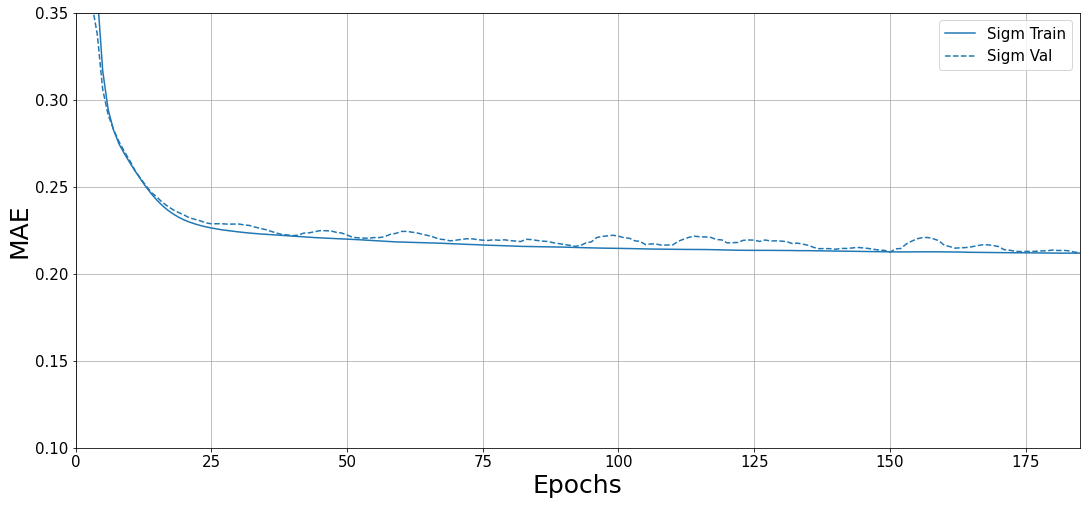

In [46]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.35])
plt.ylabel('MAE')

In [47]:
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.8735,  mae:0.7376,  mse:0.8735,  val_loss:0.5744,  val_mae:0.5759,  val_mse:0.5744,  
....................................................................................................
Epoch: 100, loss:0.1161,  mae:0.2147,  mse:0.1161,  val_loss:0.1354,  val_mae:0.2421,  val_mse:0.1354,  
....................................................................................................
Epoch: 200, loss:0.1129,  mae:0.2112,  mse:0.1129,  val_loss:0.1254,  val_mae:0.2235,  val_mse:0.1254,  
....................................................................................................

Text(0, 0.5, 'MAE')

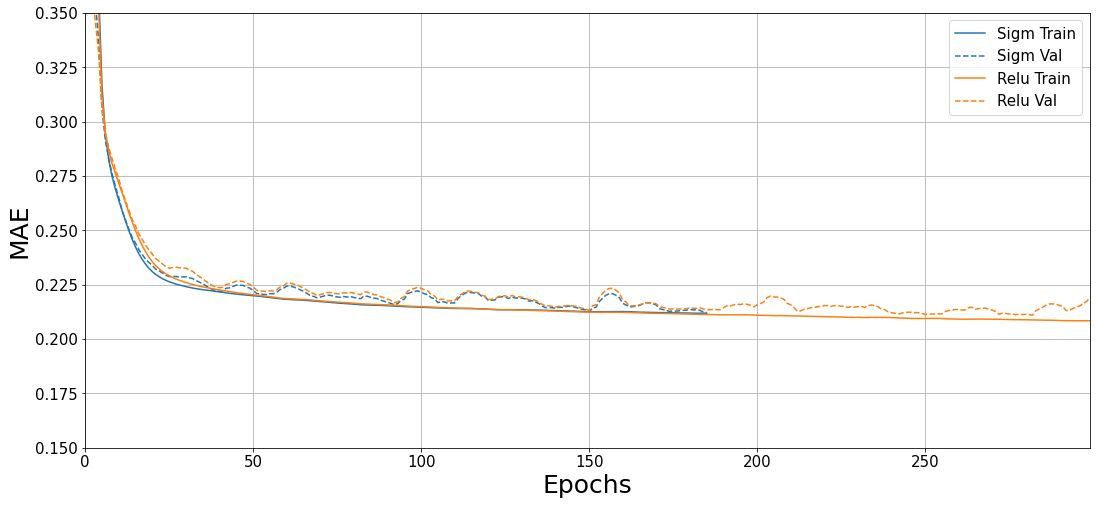

In [48]:
activ = "ReLU"
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.15, 0.35])
plt.ylabel('MAE')

In [49]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3727,  mae:0.4440,  mse:0.3727,  val_loss:0.2021,  val_mae:0.3170,  val_mse:0.2021,  
....................................................................................................
Epoch: 100, loss:0.1078,  mae:0.2071,  mse:0.1078,  val_loss:0.1188,  val_mae:0.2093,  val_mse:0.1188,  
.......................................

Text(0, 0.5, 'MAE')

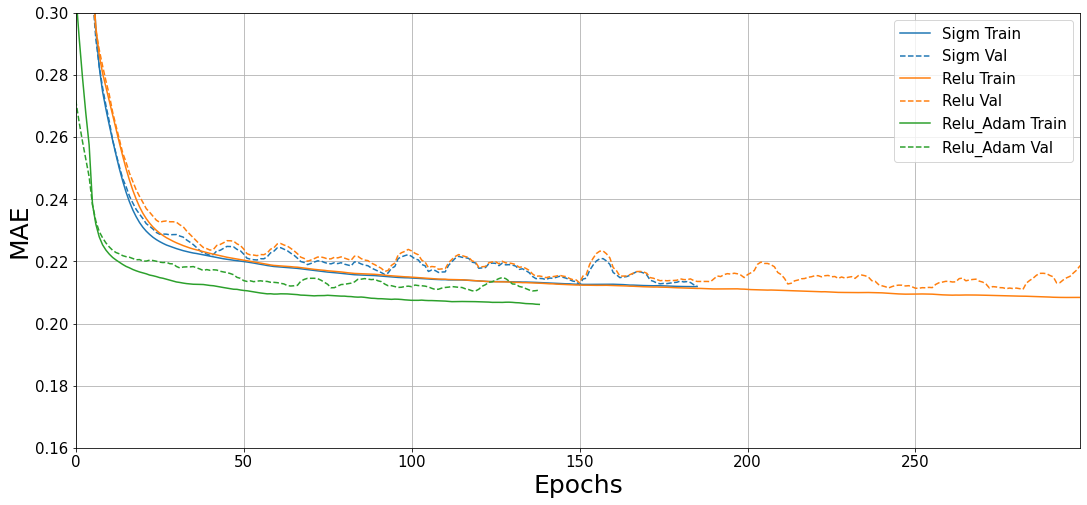

In [51]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.16, 0.3])
plt.ylabel('MAE')

In [52]:
nsize = 32
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3148,  mae:0.3800,  mse:0.3148,  val_loss:0.1808,  val_mae:0.2959,  val_mse:0.1808,  
......................................................................................

Text(0, 0.5, 'MAE')

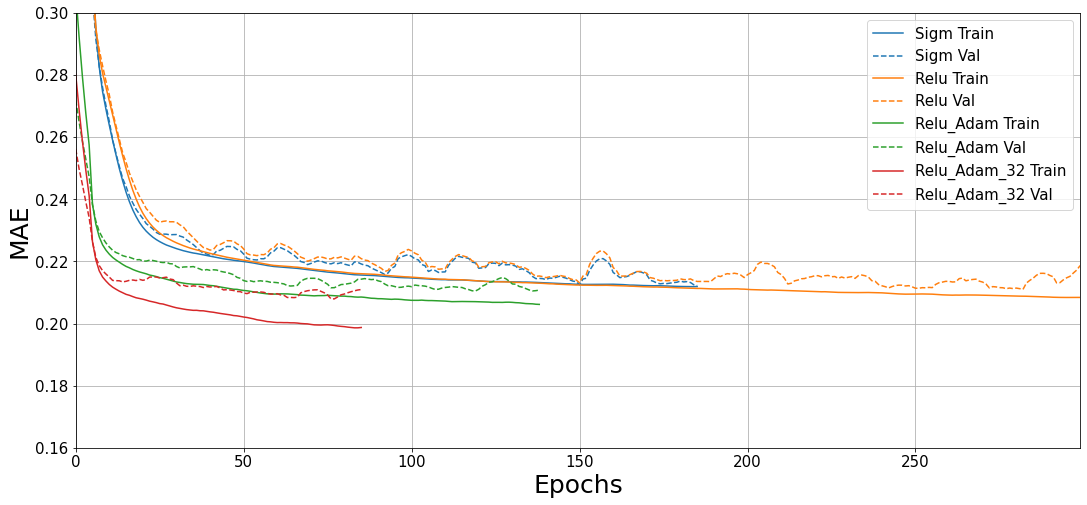

In [53]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.16, 0.3])
plt.ylabel('MAE')

In [54]:
nsize = 64
model5 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2085,  mae:0.3124,  mse:0.2085,  val_loss:0.1616,  val_mae:0.2666,  val_mse:0.1616,  
..........................................

Text(0, 0.5, 'MAE')

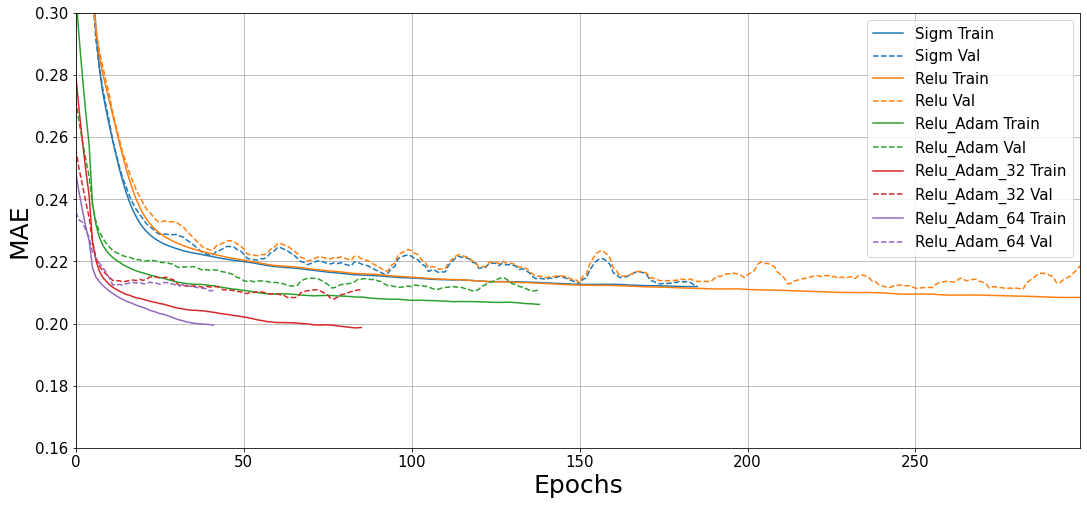

In [55]:
histories['ReLU_Adam_64'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.16, 0.3])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

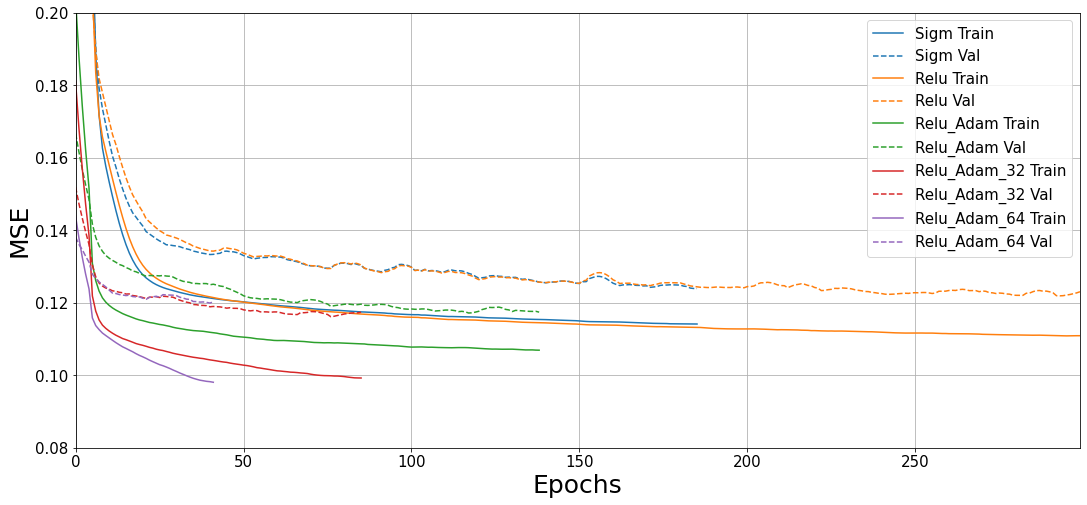

In [56]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.08, 0.2])
plt.ylabel('MSE')

In [57]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

2245/2245 - 0s - loss: 0.1021 - mae: 0.2021 - mse: 0.1021
Testing set for model 1, Mean Abs Error:    0.20206


In [58]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

2245/2245 - 0s - loss: 0.1059 - mae: 0.2129 - mse: 0.1059
Testing set for model 2, Mean Abs Error:              0.21290


In [59]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

2245/2245 - 0s - loss: 0.1018 - mae: 0.2056 - mse: 0.1018
Testing set for model 3, Mean Abs Error:              0.20563


In [60]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

2245/2245 - 0s - loss: 0.0977 - mae: 0.1986 - mse: 0.0977
Testing set for model 4, Mean Abs Error:              0.19860


In [61]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

2245/2245 - 0s - loss: 0.1011 - mae: 0.2013 - mse: 0.1011
Testing set for model 5, Mean Abs Error:              0.20128


In [62]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.20206459, 0.21290104, 0.20562862, 0.19860183, 0.2012797]

In [63]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.10214721, 0.10590197, 0.10176146, 0.09773123, 0.10109402]

In [64]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'model 1 \n sigm',
 'model 2 \n ReLU',
 'model 3 \n ReLU_Adam_16',
 'model 4 \n ReLU_Adam_32',
 'model 5 \n ReLU_Adam_64' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [65]:
test_true_num  = np.exp(test_labels.pop('rime_snow_cloud_num'))
test_true_mass = np.exp(test_labels.pop('rime_snow_cloud_mass'))

In [66]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [67]:
labels = [ "rime_snow_cloud_num", "rime_snow_cloud_mass", "rime_snow_cloud_rmass", "rime_snow_cloud_rvol" ]

p1 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=labels)

In [68]:
p1.describe()

rime_snow_cloud_num  rime_snow_cloud_mass  rime_snow_cloud_rmass  \
count          2245.000000           2245.000000            2245.000000   
mean              0.002600             -0.012468              -0.012687   
std               0.955629              0.931139               0.898505   
min              -3.541550             -2.408121              -2.472028   
25%              -0.463824             -0.737511              -0.715294   
50%               0.144686             -0.047949               0.041754   
75%               0.656618              0.719416               0.687946   
max               2.094085              2.860636               2.377290   

       rime_snow_cloud_rvol  
count           2245.000000  
mean              -0.010775  
std                0.902936  
min               -2.476203  
25%               -0.707101  
50%                0.044723  
75%                0.690864  
max                2.351899

In [69]:
train_labels_stats

count       mean       std        min        25%  \
rime_snow_cloud_num    10492.0  -0.856061  4.749022 -16.801191  -2.995732   
rime_snow_cloud_mass   10492.0 -19.499777  3.779211 -36.189266 -22.225051   
rime_snow_cloud_rmass  10492.0 -22.396618  4.168777 -40.219009 -25.220301   
rime_snow_cloud_rvol   10492.0 -27.495243  4.256905 -45.526600 -30.371558   

                             50%        75%        max  
rime_snow_cloud_num    -0.187648   2.413398   9.569636  
rime_snow_cloud_mass  -19.567626 -16.636922  -7.688995  
rime_snow_cloud_rmass -22.112307 -19.223922  -9.780677  
rime_snow_cloud_rvol  -27.179709 -24.261956 -14.791312

In [70]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [71]:
test_predict1.describe()

rime_snow_cloud_num  rime_snow_cloud_mass  rime_snow_cloud_rmass  \
count         2.245000e+03          2.245000e+03           2.245000e+03   
mean          4.533360e+01          3.999645e-07           1.514306e-08   
std           3.083505e+02          4.454605e-06           1.083466e-07   
min           2.107955e-08          3.792524e-13           6.276571e-15   
25%           4.694539e-02          2.093553e-10           9.511496e-12   
50%           8.445550e-01          2.835678e-09           2.232891e-10   
75%           9.604517e+00          5.153781e-08           3.302039e-09   
max           8.855492e+03          1.684572e-04           3.778344e-06   

       rime_snow_cloud_rvol  
count          2.245000e+03  
mean           1.057630e-10  
std            7.443304e-10  
min            3.027516e-17  
25%            5.645651e-14  
50%            1.385636e-12  
75%            2.168715e-11  
max            2.552944e-08

In [72]:
np.exp(test_dataset1.head())

qi           ni       cwc        rc
395  1.013400e-05  2322.100586  0.000116  0.000014
396  7.524601e-06  1754.800415  0.000085  0.000014
398  6.645600e-06  1385.499756  0.000036  0.000014
399  6.784200e-06  1317.199707  0.000017  0.000014
414  1.946199e-08     6.312500  0.000189  0.000014

In [73]:
test_predict1.head()

rime_snow_cloud_num  rime_snow_cloud_mass  rime_snow_cloud_rmass  \
0            10.559464          6.155287e-08           2.873744e-09   
1             4.530146          2.421528e-08           9.006180e-10   
2             1.077451          6.877229e-09           1.217044e-10   
3             0.408235          3.850440e-09           3.758555e-11   
4             0.053851          6.862337e-11           3.818519e-12   

   rime_snow_cloud_rvol  
0          1.790323e-11  
1          5.469183e-12  
2          7.285925e-13  
3          1.995732e-13  
4          2.429898e-14

In [74]:
test_dataset2.head()

qi        ni        cwc         rc        temp
395 -11.499615  7.750227  -9.061920 -11.148866  261.869995
396 -11.797333  7.470110  -9.376395 -11.148866  262.079987
398 -11.921556  7.233816 -10.243165 -11.148866  262.549988
399 -11.900914  7.183263 -10.953310 -11.148866  262.790009
414 -17.754803  1.842532  -8.573764 -11.148866  266.679993

In [75]:
test_predict1_num  = test_predict1['rime_snow_cloud_num']
test_predict1_mass = test_predict1['rime_snow_cloud_mass']

In [76]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data3), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['rime_snow_cloud_num']
test_predict2_mass = test_predict2['rime_snow_cloud_mass']


In [77]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e0, 2e5

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [78]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [79]:
amin, amax = 1e-9, 1e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [80]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [81]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [82]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [83]:
labels   = 'rime_snow_cloud_num, rime_snow_cloud_mass, rime_snow_cloud_rmass, rime_snow_cloud_rvol'
features = 'qi, ni, cwc, rc, T, rho'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)

filename = 'saved_model_v2/rime_snow_cloud_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_snow_cloud_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_snow_cloud_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_snow_cloud_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,filename)


Saving model to saved_model_v2/rime_snow_cloud_model2_13.nc
  Features:   qi, ni, cwc, rc, T, rho
  Labels:     rime_snow_cloud_num, rime_snow_cloud_mass, rime_snow_cloud_rmass, rime_snow_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear
Saving model to saved_model_v2/rime_snow_cloud_model3_13.nc
  Features:   qi, ni, cwc, rc, T, rho
  Labels:     rime_snow_cloud_num, rime_snow_cloud_mass, rime_snow_cloud_rmass, rime_snow_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layer